In [1]:
import time, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
N = 16
xx, yy = np.meshgrid(np.arange(N), np.arange(N))
rho = np.zeros((N,N))
rho[N//2, N//2] = 1.
kxx = xx[:,:N//2+1]
kyy = yy[:,:N//2+1]
rho_k = np.fft.rfft2(rho)
rho_k[0,0] = 0.0
rho = np.fft.irfft2(rho_k)
phi_k = rho_k/2./(np.cos(2.*np.pi*kxx/N)+np.cos(2.*np.pi*kyy/N)-2)
phi_k[0,0] = 0.0
phi_analytic = np.fft.irfft2(phi_k)
phi_analytic -= phi_analytic[N//2,N//2]

/home/lab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [3]:
# fig = plt.figure(figsize=(6,6), dpi=200)

# ax_1 = fig.add_subplot(1, 1, 1, projection='3d')
# surf = ax_1.plot_surface(xx, yy, phi_analytic, cmap='jet', edgecolor='none', )
# ax_1.set_title('Analytic Potential', fontsize=12, y=1.05)
# # ax_1.view_init(90, 0)
# ax_1.axis('tight')
# ax_1.set_xlim([0,N])
# ax_1.set_ylim([0,N])
# ax_1.set_xticks(np.linspace(0,N,5))
# ax_1.set_yticks(np.linspace(0,N,5))
# ax_1.set_xticklabels(np.linspace(0,N,5), fontsize=10.)
# ax_1.set_yticklabels(np.linspace(0,N,5), fontsize=10.)
# ax_1.set_zticks([])
# ax_1.set_xlabel('x', labelpad=6, fontsize=10)
# ax_1.set_ylabel('y', labelpad=6, fontsize=10)
# axins_1 = inset_axes(ax_1,
#                     width="5%",  # width = 50% of parent_bbox width
#                     height="40%",  # height : 5%
#                     loc='upper right',
#                     bbox_to_anchor=(0.1, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
#                     bbox_transform=ax_1.transAxes)
# fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_1)
# plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW3/test.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
# plt.show()

In [3]:
def LAPLACIAN_JACOBI(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx):
    return 0.25*(phi_old[neighbor_r[idx]]+phi_old[neighbor_l[idx]]+phi_old[neighbor_u[idx]]\
                 +phi_old[neighbor_d[idx]]-dx**2*source[idx])
    
def LAPLACIAN_GAUSS_SEIDEL(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] = 0.25*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]\
                              +phi_old[neighbor_u[idx_even]]+phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even])
    phi_old[idx_odd] = 0.25*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]\
                             +phi_old[neighbor_u[idx_odd]]+phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd])
    return phi_old

def LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi_old, omega, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] += 0.25*omega*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]+phi_old[neighbor_u[idx_even]]\
                                     +phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even]-4.*phi_old[idx_even])
    phi_old[idx_odd] += 0.25*omega*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]+phi_old[neighbor_u[idx_odd]]\
                                     +phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd]-4.*phi_old[idx_odd])
    return phi_old
    
def CALCULATE_CRITERIA(phi, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d):
    diff = (1./dx**2*(phi[neighbor_r]+phi[neighbor_l]+phi[neighbor_u]+phi[neighbor_d]-4.*phi)-source)
    return (diff**2).mean()

In [4]:
phi = np.zeros(N*N)
rho = rho.ravel()
iteration = 0
iteration_max = 100000

dx = 1
show_error_interval = 1000
# mode = 'jacobi'
# mode = 'gauss_seidel'
mode = 'SOR'

neighbor_r = np.arange(N*N)
neighbor_l = np.arange(N*N)
neighbor_u = np.arange(N*N)
neighbor_d = np.arange(N*N)
neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
# criteria = CALCULATE_CRITERIA(phi_analytic.ravel(), rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
criteria = 1e-21
error_cache = error
if mode=='jacobi':
    phi_copy = np.empty(N*N)
    idx_all = np.arange(N*N)
    idx = idx_all[idx_all!=N//2+N*(N//2)]
    flag = True
elif mode=='gauss_seidel' or mode=='SOR':
    idx_all = np.arange(N*N)
    idx_even = idx_all[(idx_all%2==0)&(idx_all!=N//2+N*(N//2))]
    idx_odd = idx_all[(idx_all%2==1)&(idx_all!=N//2+N*(N//2))]
    if mode == 'SOR':
        omega = 1.33
start = time.time()
while error>criteria and iteration<iteration_max:
    if mode=='jacobi':
        if flag:
            phi_copy[idx] = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx)
            error = CALCULATE_CRITERIA(phi_copy, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        else:
            phi[idx]  = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx)
            error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        flag = not flag
    elif mode=='gauss_seidel':
        phi = LAPLACIAN_GAUSS_SEIDEL(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
    else:
        phi = LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi, omega, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
    iteration += 1
    phi -= phi[N//2+(N//2)*N]
    if iteration%show_error_interval == 0:
        print("Iteration = %d, error = %.8e , criteria = %.4e ."%(iteration, error, criteria))
        if error_cache<error:
            break
        else:
            error_cache = error
if mode=='jacobi':
    if flag:
        phi = phi.copy()
end = time.time()
print("Simulation of %s scheme ends. Total %.2f s is spent."%(mode, end-start))
print("Error %.8e has been reached, total iterations is %d ."%(error, iteration))
phi = np.array(phi.reshape(N,N))

Iteration = 1000, error = 1.52564409e-06 , criteria = 1.0000e-21 .
Iteration = 2000, error = 6.13693200e-10 , criteria = 1.0000e-21 .
Iteration = 3000, error = 2.46859246e-13 , criteria = 1.0000e-21 .
Iteration = 4000, error = 9.92995976e-17 , criteria = 1.0000e-21 .
Iteration = 5000, error = 3.99434589e-20 , criteria = 1.0000e-21 .
Simulation of SOR scheme ends. Total 0.20 s is spent.
Error 9.97168225e-22 has been reached, total iterations is 5472 .


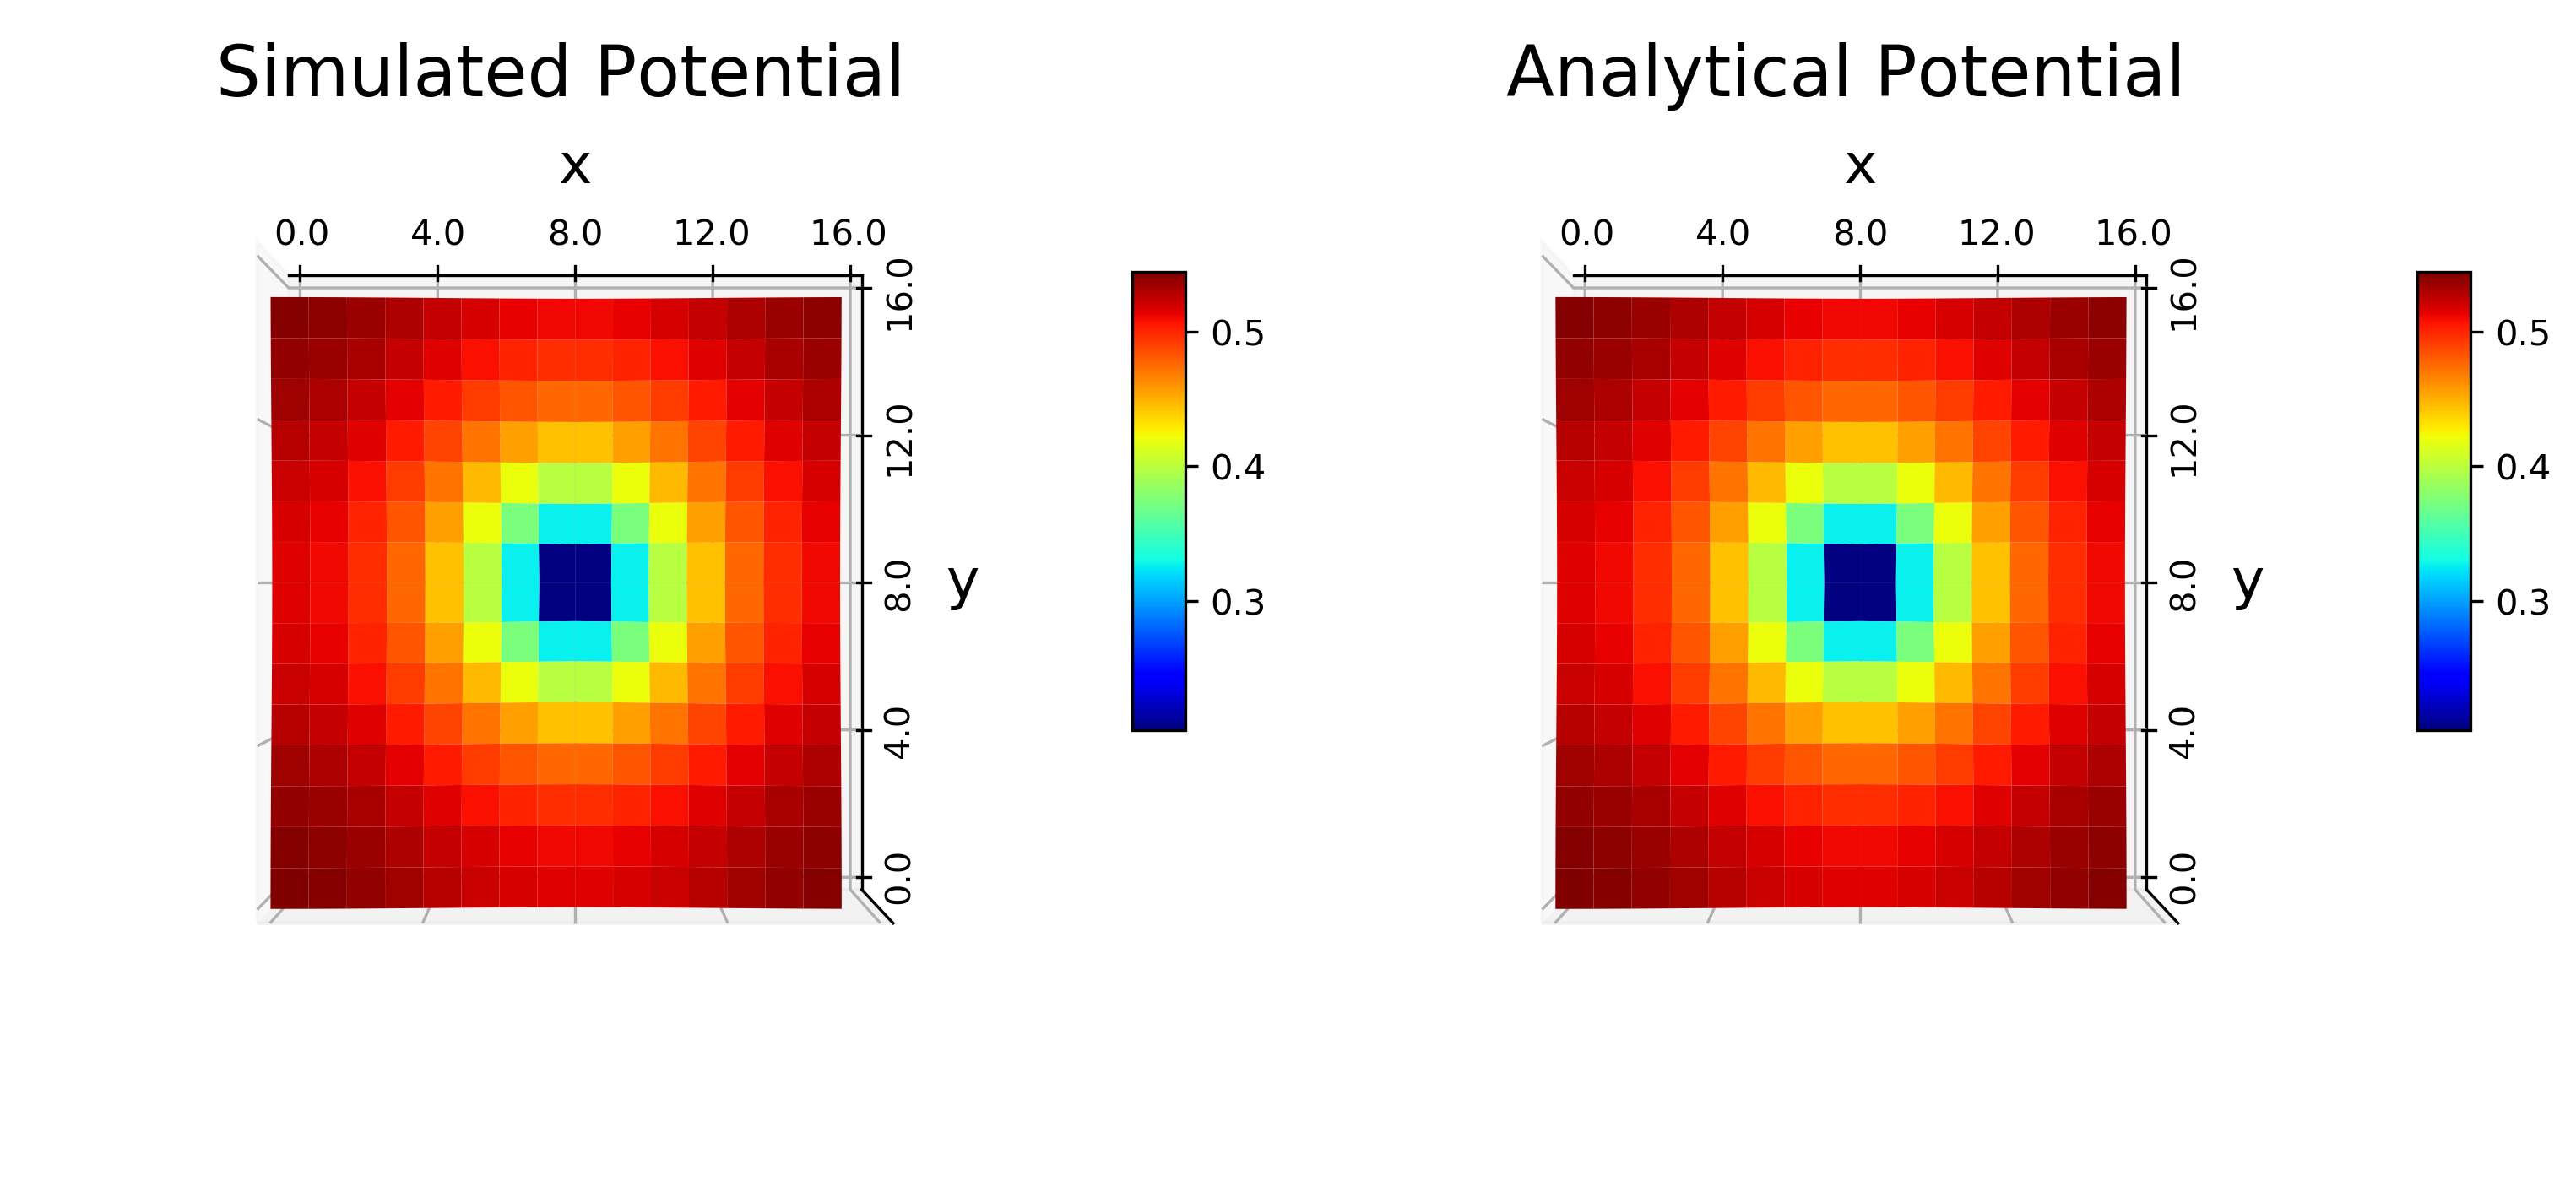

In [5]:
fig = plt.figure(figsize=(2*6,6), dpi=300)

ax_1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax_1.plot_surface(xx, yy, phi, cmap='jet', edgecolor='none', )
ax_1.set_title('Simulated Potential', fontsize=20, y=1.0)
ax_1.view_init(90, -90)
ax_1.axis('tight')
ax_1.set_xlim([0,N])
ax_1.set_ylim([0,N])
ax_1.set_xticks(np.linspace(0,N,5))
ax_1.set_yticks(np.linspace(0,N,5))
ax_1.set_xticklabels(np.linspace(0,N,5), fontsize=10., va='center')
ax_1.set_yticklabels(np.linspace(0,N,5), fontsize=10., rotation=90, va='center')
ax_1.set_zticks([])
ax_1.set_xlabel('x', labelpad=10, fontsize=16)
ax_1.set_ylabel('y', labelpad=10, fontsize=16)
axins_1 = inset_axes(ax_1,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.1, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_1.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_1)

ax_2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax_2.plot_surface(xx, yy, phi_analytic, cmap='jet', edgecolor='none')
ax_2.set_title('Analytical Potential', fontsize=20, y=1.0)
ax_2.view_init(90, -90)
ax_2.axis('tight')
ax_2.set_xlim([0,N])
ax_2.set_ylim([0,N])
ax_2.set_xticks(np.linspace(0,N,5))
ax_2.set_yticks(np.linspace(0,N,5))
ax_2.set_xticklabels(np.linspace(0,N,5), fontsize=10., va='center')
ax_2.set_yticklabels(np.linspace(0,N,5), fontsize=10., rotation=90, va='center')
ax_2.set_zticks([])
ax_2.set_xlabel('x', labelpad=10, fontsize=16.)
ax_2.set_ylabel('y', labelpad=10, fontsize=16.)
axins_2 = inset_axes(ax_2,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.1, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_2.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_2)
plt.show()

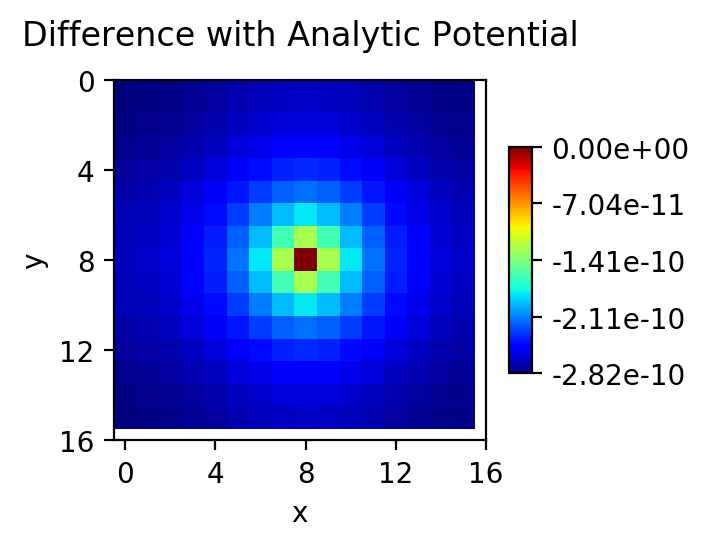

In [6]:
difference = phi-phi_analytic
ticks=np.linspace(difference.min(), difference.max(),5)

fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.imshow(difference, cmap='jet')
plt.title("Difference with Analytic Potential", y=1.05)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.linspace(0,N,5))
plt.yticks(np.linspace(0,N,5))
fig.colorbar(ax, shrink=0.5, aspect=10, ticks=ticks, format='%.2e')
plt.show()

In [7]:
rho = rho.ravel()
iteration = 0
iteration_max = 2000000

dx = 1
show_error_interval = 1000
omega_range = np.arange(0.01, 1.34, 0.01)
# criteria = 1.1*CALCULATE_CRITERIA(phi_analytic.ravel(), rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
criteria = 1e-21

neighbor_r = np.arange(N*N)
neighbor_l = np.arange(N*N)
neighbor_u = np.arange(N*N)
neighbor_d = np.arange(N*N)
neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

idx_all = np.arange(N*N)
idx_even = idx_all[(idx_all%2==0)&(idx_all!=N//2+N*(N//2))]
idx_odd = idx_all[(idx_all%2==1)&(idx_all!=N//2+N*(N//2))]

iteration_record = []
total_time_record = []
error_record = []

print("Test the optimal omega for SOR scheme.")
for omega in omega_range:
    ### reinitialize the field and parameters
    phi = np.zeros(N*N)
    iteration = 0
    error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
    error_cache = error
    ###
    
    start = time.time()
    while error>criteria and iteration<iteration_max: 
        phi = LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi, omega, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        iteration += 1
        if iteration%show_error_interval == 0:
#             print("\tIteration = %d, error = %.4e , criteria is %.4e ."%(iteration, error, criteria))
            if error_cache<error:
                break
            else:
                error_cache = error
    end = time.time()
    print("Simulation of omega = %.4e ends. Total %.2f s is spent."%(omega, end-start))
    print("Error %.4e has been reached, total iterations is %d ."%(error, iteration))
    iteration_record.append(iteration)
    total_time_record.append(end-start)
    error_record.append(error)

phi = np.array(phi.reshape(N,N))
error_record = np.array(error_record)
iteration_record = np.array(iteration_record)
total_time_record = np.array(total_time_record)

Test the optimal omega for SOR scheme.
Simulation of omega = 1.0000e-02 ends. Total 40.01 s is spent.
Error 9.9999e-22 has been reached, total iterations is 1089187 .
Simulation of omega = 2.0000e-02 ends. Total 19.95 s is spent.
Error 9.9997e-22 has been reached, total iterations is 543184 .
Simulation of omega = 3.0000e-02 ends. Total 13.26 s is spent.
Error 9.9992e-22 has been reached, total iterations is 361202 .
Simulation of omega = 4.0000e-02 ends. Total 9.90 s is spent.
Error 9.9996e-22 has been reached, total iterations is 270214 .
Simulation of omega = 5.0000e-02 ends. Total 7.92 s is spent.
Error 9.9987e-22 has been reached, total iterations is 215623 .
Simulation of omega = 6.0000e-02 ends. Total 6.58 s is spent.
Error 9.9996e-22 has been reached, total iterations is 179229 .
Simulation of omega = 7.0000e-02 ends. Total 5.65 s is spent.
Error 9.9996e-22 has been reached, total iterations is 153234 .
Simulation of omega = 8.0000e-02 ends. Total 4.93 s is spent.
Error 9.9984e

Simulation of omega = 6.7000e-01 ends. Total 0.50 s is spent.
Error 9.9810e-22 has been reached, total iterations is 13560 .
Simulation of omega = 6.8000e-01 ends. Total 0.49 s is spent.
Error 9.9918e-22 has been reached, total iterations is 13320 .
Simulation of omega = 6.9000e-01 ends. Total 0.48 s is spent.
Error 9.9686e-22 has been reached, total iterations is 13088 .
Simulation of omega = 7.0000e-01 ends. Total 0.47 s is spent.
Error 9.9992e-22 has been reached, total iterations is 12861 .
Simulation of omega = 7.1000e-01 ends. Total 0.47 s is spent.
Error 9.9760e-22 has been reached, total iterations is 12642 .
Simulation of omega = 7.2000e-01 ends. Total 0.46 s is spent.
Error 9.9897e-22 has been reached, total iterations is 12428 .
Simulation of omega = 7.3000e-01 ends. Total 0.45 s is spent.
Error 9.9987e-22 has been reached, total iterations is 12220 .
Simulation of omega = 7.4000e-01 ends. Total 0.44 s is spent.
Error 9.9943e-22 has been reached, total iterations is 12018 .


Simulation of omega = 1.3300e+00 ends. Total 0.20 s is spent.
Error 9.9717e-22 has been reached, total iterations is 5472 .


In [8]:
try: 
    os.makedirs('./Optimal_Omega_Test_Periodic_dx=1')
except:
    print("Folder already existed!")
path = './Optimal_Omega_Test_Periodic_dx=1/'

data = np.vstack((omega_range, iteration_record,error_record, total_time_record)).T
np.savetxt('%sN=%d_criteria=%.8e_optimal_omega_record.txt'%(path, N, criteria), data, fmt="%.8e",\
           header='Omega\tIteration(s)\tError\tTotal_Time (s)',\
           footer='Stopping Criteria: %.8e'%criteria)

Folder already existed!


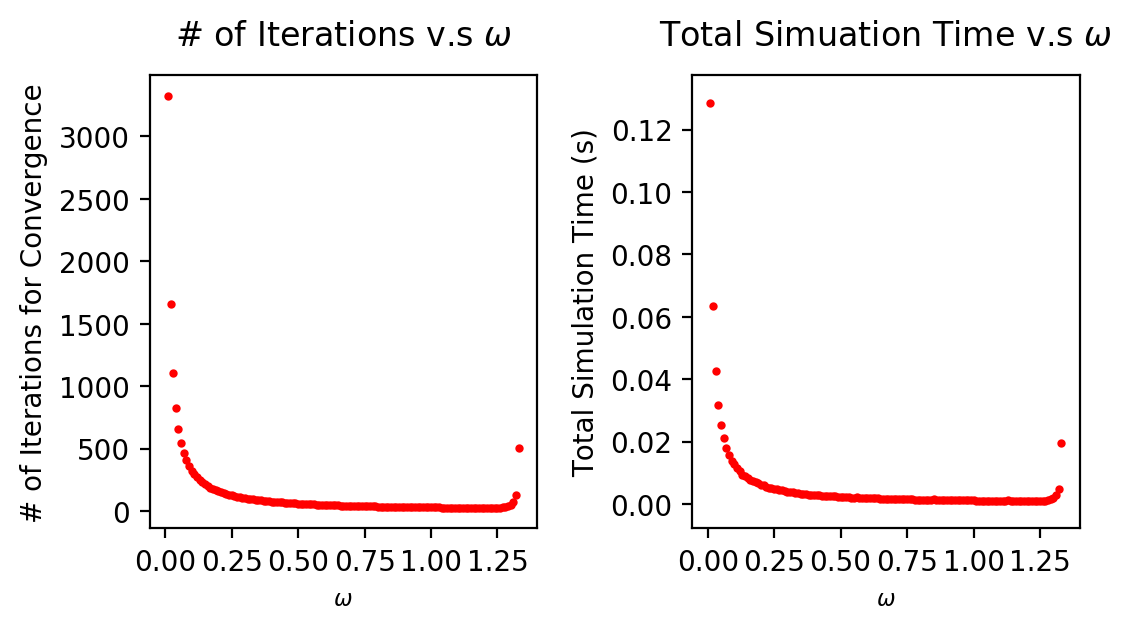

In [381]:
name = 'N=16_criteria=2.0480e-05_optimal_omega_record.txt'
data = np.loadtxt('%s%s'%(path, name))
omega_range, iteration_record, error_record, total_time_record = data[:,0], data[:,1], data[:,2], data[:,3]
criteria = eval(name.split('_')[1].split('=')[-1])

fig = plt.figure(figsize=(2*3,3), dpi=200)
plt.subplots_adjust(wspace=0.4)
ax_1 = plt.subplot(121)
ax_1.scatter(omega_range[error_record<criteria], iteration_record[error_record<criteria], s=4.0, c='r')
ax_1.set_xlabel('$\omega$', fontsize=8.)
ax_1.set_ylabel('# of Iterations for Convergence')
ax_1.set_title('# of Iterations v.s $\omega$',y=1.03)
ax_1.set_xticks(np.arange(0,1.35,0.25))

ax_2 = plt.subplot(122)
ax_2.scatter(omega_range[error_record<criteria], total_time_record[error_record<criteria], s=4.0, c='r')
ax_2.set_xlabel('$\omega$', fontsize=8.)
ax_2.set_ylabel('Total Simulation Time (s)')
ax_2.set_title('Total Simuation Time v.s $\omega$',y=1.03)
ax_2.set_xticks(np.arange(0,1.35,0.25))
plt.show()

### For Convention Check of numpy fft2

In [181]:
# signal = np.cos(3./N*2.*np.pi*xx)*np.cos(2./N*2.*np.pi*yy)
# signal_k = np.fft.rfft2(signal)
# for i in range(signal_k.shape[0]):
#     for j in range(signal_k.shape[1]):
#         print("(%d,%d)\t%.4e\t%.4e"%(i, j, signal_k[i,j].real,signal_k[i,j].imag))
# signal_k[2,3]